# Using H2O Machine Learning and Kalman Filters for Machine Prognostics

## IoT Data Comes From Lots of Places, much of it from sensors

<img src="https://gkapteina.files.wordpress.com/2015/08/br-internet-of-things-ecosystem.jpg">

## The data is going to be huge, so get ready
<img src="http://www8.hp.com/h30458/media2.php/EZINE/April%20infographics/APR_IM_INFOG.jpg?version=349e115e815fac03bd19756911efee13">

## Wow, how big is a brontobyte?
<img src="bronto.png">

# This much data will require a fast OODA loop
## Much of these models will then be used in control systems
<img src="http://www.telecom-cloud.net/wp-content/uploads/2015/05/Screen-Shot-2015-05-27-at-3.51.47-PM.png">


## Machine Learning Prognostics for Turbofan Engine Degradation Dataset

Information about the problem is at http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/publications/#turbofan and original data is at http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/#turbofan

The data was originally generated using the Commercial Modular Aero-Propulsion System Simulations (C-MAPPS) system.

The approach used in the turbofan engine degradation dataset was then used in the PHM08 challenge.  Information about other research on the C-MAPSS data is available at  https://www.phmsociety.org/sites/phmsociety.org/files/phm_submission/2014/phmc_14_063.pdf

## Sometimes the simple things work
"The <b>quickest and
simplest method for representing time is to consider each time
point independently and create a prediction at each time step</b>.

An alternative representation would be to consider using a
phase space embedding representation, in which a sequence of
instances is generated using a fixed length sliding window.
However <b>phase space embedding has the significant drawback
of increasing the number of dimensions proportionally with
each time step represented, giving rise to the problems
associated with the 'curse of dimensionality'</b>.".

Leto Peel, Member, IEEE (GOLD) " Data Driven Prognostics using a
Kalman Filter Ensemble of Neural Network Models" 2008
international conference on prognostics and health management.

## The approach of treating each time point independently will be used

# Import and initialize h2o

In [28]:
import h2o

In [29]:
h2o.init()



No instance found at ip and port: localhost:54321. Trying to start local jar...


JVM stdout: /var/folders/wg/3qx1qchx1jsfjqqbmz3stj7c0000gn/T/tmpRknVWm/h2o_hank_started_from_python.out
JVM stderr: /var/folders/wg/3qx1qchx1jsfjqqbmz3stj7c0000gn/T/tmpt8fQh8/h2o_hank_started_from_python.err
Using ice_root: /var/folders/wg/3qx1qchx1jsfjqqbmz3stj7c0000gn/T/tmpqNIX5S


Java Version: java version "1.8.0_40"
Java(TM) SE Runtime Environment (build 1.8.0_40-b27)
Java HotSpot(TM) 64-Bit Server VM (build 25.40-b25, mixed mode)


Starting H2O JVM and connecting: ............. Connection successful!


H2O cluster uptime:,1 seconds 528 milliseconds
H2O cluster version:,3.8.0.4
H2O cluster name:,H2O_started_from_python_hank_khr419
H2O cluster total nodes:,1
H2O cluster total free memory:,3.56 GB
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321
H2O Connection proxy:,None


# Define the names of the features
These are both the features in the original data file and some of the features that will be created later on.

In [30]:
# Setup the column names of the training file
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

# And the name of the to be engineered target variable
dependent_var = ['RemainingUsefulLife']

# And some variables that will be engineered later
operating_modes = 6 # known a priori from dataset description
operating_mode_column_name = ["OperatingMode"]
operating_mode_cummulative_name = ["CountInMode"+str(i) for i in range(0,operating_modes)]

# Import the training and test sets, look at summary statistics

In [31]:
train = h2o.upload_file("train_augmented_FD004.txt")
test  = h2o.upload_file("test_FD004.txt")
train.set_names(input_file_column_names);
test.set_names(input_file_column_names);


Parse Progress: [##################################################] 100%

Parse Progress: [##################################################] 100%


In [32]:
train.describe()

Rows:183,498 Cols:26

Chunk compression summary: 


chunk_type,chunk_name,count,count_percentage,size,size_percentage
C1,1-Byte Integers,7,3.846154,179.7 KB,1.8887892
C1N,1-Byte Integers (w/o NAs),2,1.0989012,50.5 KB,0.5304244
C1S,1-Byte Fractions,26,14.285715,668.6 KB,7.0290036
C2,2-Byte Integers,14,7.692308,717.7 KB,7.5453835
C2S,2-Byte Fractions,112,61.538464,5.6 MB,60.381462
C4S,4-Byte Fractions,21,11.538462,2.1 MB,22.624939



Frame distribution summary: 


,size,number_of_rows,number_of_chunks_per_column,number_of_chunks
127.0.0.1:54321,9.3 MB,183498.0,7.0,182.0
mean,9.3 MB,183498.0,7.0,182.0
min,9.3 MB,183498.0,7.0,182.0
max,9.3 MB,183498.0,7.0,182.0
stddev,0 B,0.0,0.0,0.0
total,9.3 MB,183498.0,7.0,182.0


,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
type,int,int,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,int,real,real,real
mins,1.0,1.0,0.0,0.0,60.0,445.0,535.48,1242.67,1024.42,3.91,5.67,136.17,1914.72,7984.51,0.93,36.04,128.31,2027.57,7845.78,8.1757,0.02,302.0,1915.0,84.93,10.16,6.0843
mean,372.986381323,134.493672956,23.9984239311,0.571331659201,94.0317605641,472.884631331,579.423195784,1417.90813224,1201.92919209,8.03193936719,11.5899203806,283.34144334,2228.69307736,8524.70833644,1.09645418479,42.8748880642,266.747734526,2334.42939651,8067.82334957,9.28556634514,0.0232530054823,347.763000142,2228.62019205,97.7514657925,20.8651955335,12.5195196536
maxs,747.0,544.0,42.008,0.842,100.0,518.67,644.42,1613.0,1440.77,14.62,21.61,570.81,2388.64,9196.81,1.32,48.36,537.49,2390.49,8261.65,11.0663,0.03,399.0,2388.0,100.0,39.89,23.8852
sigma,215.612861027,89.7109970004,14.7800862129,0.310700018707,14.2516947186,26.4360973348,37.3420691935,106.166481083,119.325941263,3.6227190296,5.44380686103,146.875979788,145.347143879,336.92523708,0.127680743769,3.24348106926,138.475050637,128.195530872,85.6715193409,0.750379357135,0.00468488311113,27.80793194,145.471396206,5.36932598525,9.93606236939,5.96250611308
zeros,0,0,484,14305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,1.0,42.0049,0.84,100.0,445.0,549.68,1343.43,1112.93,3.91,5.7,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330.0,2212.0,100.0,10.62,6.367
1,1.0,2.0,20.002,0.7002,100.0,491.19,606.07,1477.61,1237.5,9.35,13.61,332.1,2323.66,8713.6,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361.0,2324.0,100.0,24.37,14.6552
2,1.0,3.0,42.0038,0.8409,100.0,445.0,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329.0,2212.0,100.0,10.48,6.4213


# Target creation
Create the target field, remaining useful life, by determining the total cycles for each of the training units and then calculating the number of cycles remaining.

In [33]:
def add_remaining_useful_life(h2o_frame):
    # Get the total number of cycles for each unit
    grouped_by_unit = h2o_frame.group_by(by=["UnitNumber"])
    max_cycle = grouped_by_unit.max(col="Cycle").frame
    
    # Merge the max cycle back into the original frame
    result_frame = h2o_frame.merge(max_cycle)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_Cycle"] - \
                            result_frame["Cycle"]
    result_frame["RemainingUsefulLife"] = remaining_useful_life
    
    # drop the un-needed column
    result_frame = result_frame.drop("max_Cycle")
    return result_frame

train_with_predictor = add_remaining_useful_life(train)

# Exploratory data analysis

In [34]:
# For some EDA
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Sample a few units and pull from H2O memory space to the Python memory space

In [35]:
sample_units = train_with_predictor["UnitNumber"] < 3
train_pd = train_with_predictor[sample_units].as_data_frame(use_pandas=True)

#### The sensor data does not show any trends over time, making it difficult to make predictions about the future from the observed data

//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


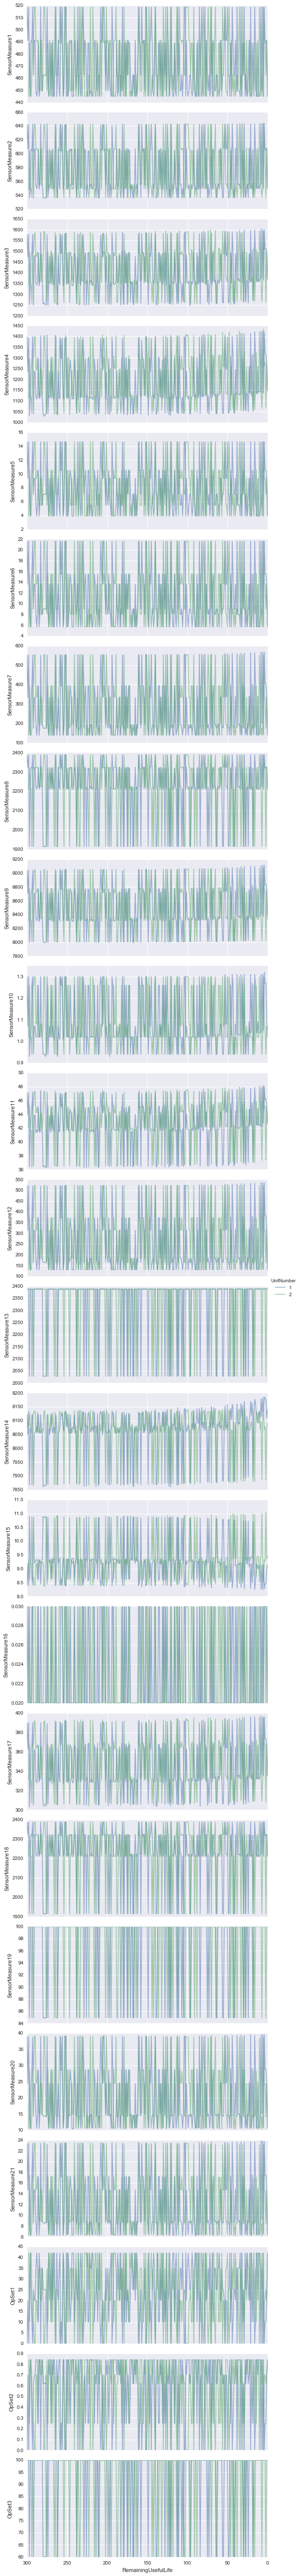

In [36]:
g = sns.PairGrid(data=train_pd,
                 x_vars=dependent_var,
                 y_vars=sensor_measure_columns_names + \
                        operational_settings_columns_names,
                 hue="UnitNumber", size=3, aspect=2.5)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(300,0))
g = g.add_legend()

#### The sensor measurements happen in 6 clusters; this happens to coincide with the operating modes

//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


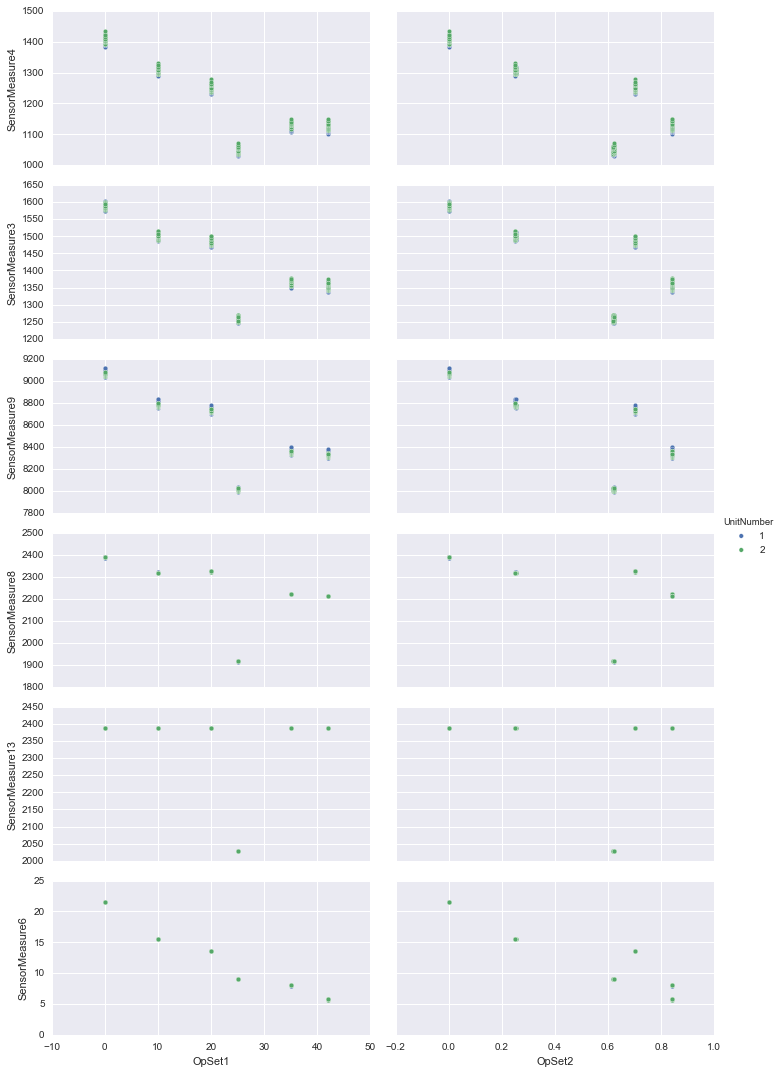

In [37]:
g = sns.pairplot(data=train_pd,
                 x_vars=["OpSet1","OpSet2"],
                 y_vars=["SensorMeasure4", "SensorMeasure3", 
                         "SensorMeasure9", "SensorMeasure8", 
                         "SensorMeasure13", "SensorMeasure6"],
                 hue="UnitNumber", aspect=2)

# Feature Engineering
Use machine learning to label each observation, corresponding the the six operating modes of the units.

In [38]:
from h2o.estimators.kmeans import H2OKMeansEstimator

In [39]:
operating_mode_estimator = H2OKMeansEstimator(k=operating_modes)
operating_mode_estimator.train(x=operational_settings_columns_names,
                              training_frame=train_with_predictor)


kmeans Model Build Progress: [##################################################] 100%


In [40]:
def append_operating_mode(h2o_frame, estimator):
    operating_mode_labels = estimator.predict(h2o_frame)
    operating_mode_labels.set_names(operating_mode_column_name);
    operating_mode_labels = operating_mode_labels.asfactor()
    h2o_frame_augmented = h2o_frame.cbind(operating_mode_labels)
    return h2o_frame_augmented

train_augmented = append_operating_mode(train_with_predictor,operating_mode_estimator)
test_augmented = append_operating_mode(test,operating_mode_estimator)

### Use visualization to review that clustering happened as expected

In [41]:
train_pd = train_augmented[sample_units].as_data_frame(use_pandas=True)

//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


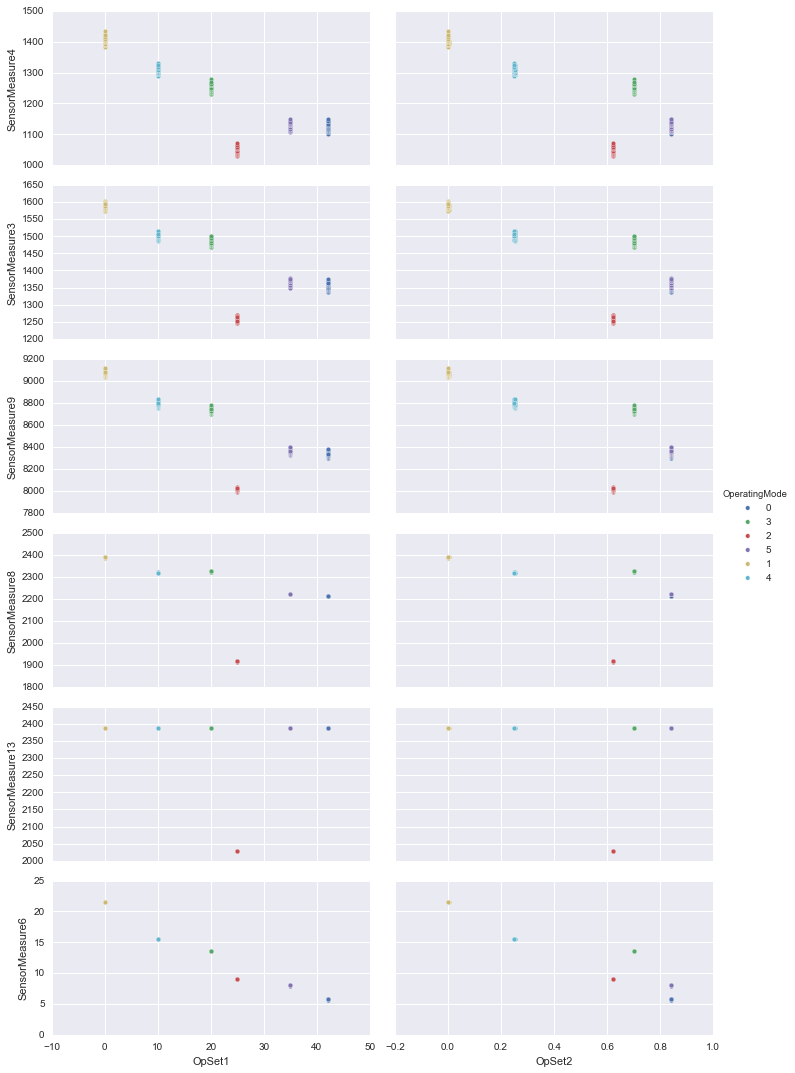

In [42]:
g = sns.pairplot(data=train_pd,
                 x_vars=["OpSet1","OpSet2"],
                 y_vars=["SensorMeasure4", "SensorMeasure3", "SensorMeasure9", "SensorMeasure8", "SensorMeasure13", "SensorMeasure6"],
                 hue=operating_mode_column_name[0], aspect=2)

# More Feature engineering
Standardize the sensor measurements based on the mean and standard deviation within each operating mode, from the training data.  

Ignore the sensors with constant measurements within an operating mode.

Apply to both training and test data.

In [43]:
def standardize_by_operating_mode(train, test):
    t = train.group_by(operating_mode_column_name).\
        mean(sensor_measure_columns_names).\
        sd(sensor_measure_columns_names).frame

    s = train.merge(t, all_x=True)
    r = test.merge(t, all_x=True)

    standardize_measures_columns_names = []
    for sensor_measure_column_name in sensor_measure_columns_names:
        include_this_measure = True
        # if any of the operating modes shows 0 or NaN standard deviation, 
        # do not standardize that sensor measure,b
        # nor use it in the model building
        for i in range(0,operating_modes):
            stdev = t[t["OperatingMode"] == str(i),"sdev_"+sensor_measure_column_name][0,0]
            if stdev == 0.0: 
                include_this_measure = False
                break
        if include_this_measure:
            new_column_name = "stdized_"+sensor_measure_column_name
            standardize_measures_columns_names.append(new_column_name)
            s[new_column_name] = ((s[sensor_measure_column_name]-
                                   s["mean_"+sensor_measure_column_name])/
                                   s["sdev_"+sensor_measure_column_name])
            r[new_column_name] = ((r[sensor_measure_column_name]-
                                   r["mean_"+sensor_measure_column_name])/
                                   r["sdev_"+sensor_measure_column_name])
    return (s,r,standardize_measures_columns_names)

train_stdized, test_stdized, standardized_measures_columns_names = \
    standardize_by_operating_mode(train_augmented, test_augmented)

### Use visualization to understand the impact

In [44]:
sample_units2 = train_with_predictor["UnitNumber"] < 6
train_pd = train_stdized[sample_units2].as_data_frame(use_pandas=True)

## Trends over time!!

//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


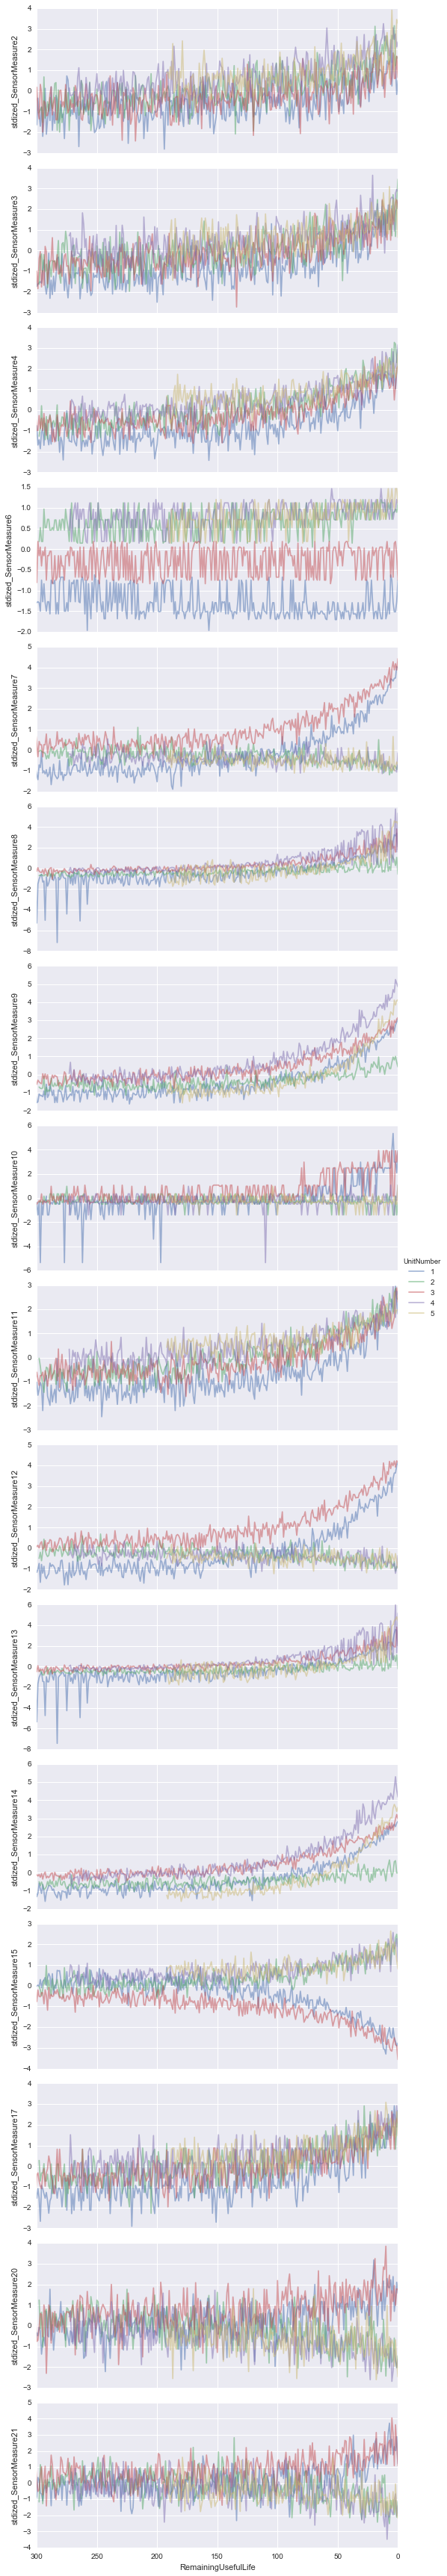

In [45]:
g = sns.PairGrid(data=train_pd,
                 x_vars=dependent_var,
                 y_vars=standardized_measures_columns_names,
                 hue="UnitNumber", size=3, aspect=2.5)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(300,0))
g = g.add_legend()

In [46]:
def add_cummulative_in_mode(frame):
    print 'Starting func, getting data'
    g = frame[['UnitNumber','OperatingMode','Cycle']].as_data_frame(use_pandas=True) # Get the smallest data needed
    for k in range(0,operating_modes):
        print 'loop one k=' + str(k)
        g['One'+str(k)] = 1*(g['OperatingMode']==k)
    for k in range(0,operating_modes):
        print 'loop two k=' + str(k)
        g['CountInMode'+str(k)] = g.groupby(['UnitNumber'])['One'+str(k)].cumsum()
        g.drop('One'+str(k), axis=1, inplace=True)
    
    g.drop('OperatingMode', axis=1, inplace=True)  # Not needed for the join, no reason to send back to H2O
    print 'Sending back to h2o'
    h = h2o.H2OFrame.from_python(g.to_dict(orient='list'))
    print 'Merging'
    i = frame.merge(h)
    print 'Forcing merge'
    i.columns; # Force the merge to happen, not lazily
    return i

In [47]:
train_final = add_cummulative_in_mode(train_stdized)
test_final = add_cummulative_in_mode(test_stdized)

Starting func, gettig data
loop one k=0
loop one k=1
loop one k=2
loop one k=3
loop one k=4
loop one k=5
loop two k=0
loop two k=1
loop two k=2
loop two k=3
loop two k=4
loop two k=5
Sending back to h2o

Parse Progress: [##################################################] 100%
Merging
Forcing merge
Starting func, gettig data
loop one k=0
loop one k=1
loop one k=2
loop one k=3
loop one k=4
loop one k=5
loop two k=0
loop two k=1
loop two k=2
loop two k=3
loop two k=4
loop two k=5
Sending back to h2o

Parse Progress: [##################################################] 100%
Merging
Forcing merge


In [48]:
h2o.export_file(train_final,"/Users/hank/Projects/PrognosticsExample/train_FD004_processed.csv", force=True)
h2o.export_file(test_final,"/Users/hank/Projects/PrognosticsExample/test_FD004_processed.csv", force=True)


Export File Progress: [##################################################] 100%

Export File Progress: [##################################################] 100%


In [49]:
h2o.shutdown()

Are you sure you want to shutdown the H2O instance running at localhost:54321 (Y/N)? Y
